**PROGRAMMING ASSIGNMENT 6**

QUESTION 1.   
NEURAL NETWORK

In [18]:
import os
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


TASK 0

In [8]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(size=28, padding=4),  # Assuming MNIST 28x28 images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std dev
])

In [9]:
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [10]:
train_size = int(0.9 * len(train_data))
validation_size = len(train_data) - train_size
train_dataset, validation_dataset = random_split(train_data, [train_size, validation_size])

TASK 1

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [13]:
def get_images_for_each_class(data_loader, num_images_per_class=3):
    class_images = {i: [] for i in range(10)}  # Create a dictionary to store images class-wise
    class_counts = {i: 0 for i in range(10)}

    # Iterate over the data loader
    for images, labels in data_loader:
        for image, label in zip(images, labels):
            label = label.item()
            if class_counts[label] < num_images_per_class:
                class_images[label].append(image)
                class_counts[label] += 1
            # Check if we have enough images for each class
            if all(count >= num_images_per_class for count in class_counts.values()):
                break
        else:
            continue
        break

    return class_images

class_images = get_images_for_each_class(train_loader)


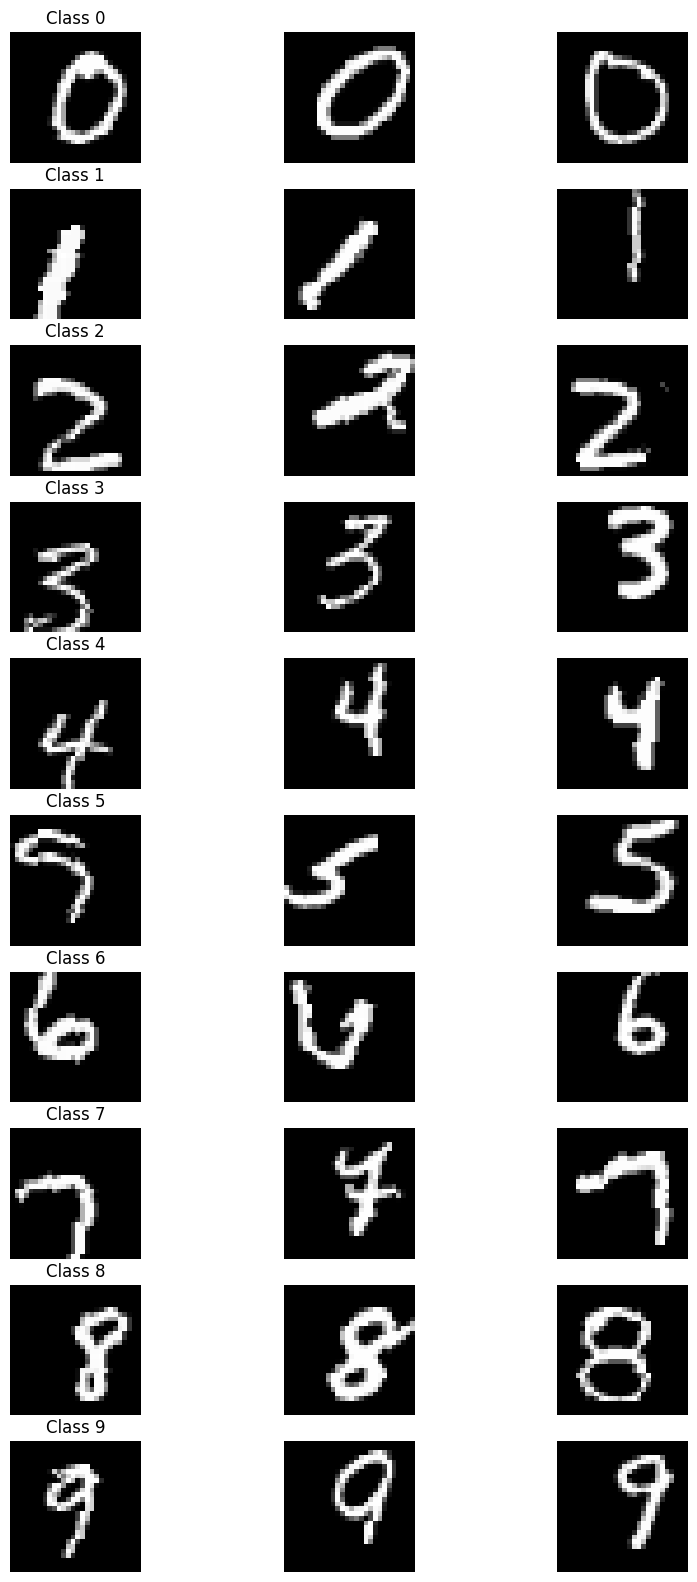

In [14]:
def plot_class_images(class_images):
    fig, axs = plt.subplots(10, 3, figsize=(10, 20))  # Adjust the size as needed
    for class_idx, images in class_images.items():
        for i, image in enumerate(images):
            axs[class_idx, i].imshow(image.squeeze(), cmap='gray')
            axs[class_idx, i].axis('off')
            if i == 0:
                axs[class_idx, i].set_title(f'Class {class_idx}')
    plt.show()

plot_class_images(class_images)

TASK 2

In [16]:
def create_three_layer_mlp():
    model = nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    return model

In [17]:
model = create_three_layer_mlp()
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters:", count_parameters(model))

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)
Number of trainable parameters: 109386


TASK 3

In [19]:
#settup loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [26]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move data to the appropriate device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs.view(inputs.shape[0], -1))  # Reshape inputs and forward pass
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc

In [32]:
def validate_model(model, validation_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    correct_samples = []
    incorrect_samples = []

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.view(inputs.shape[0], -1))
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect correct and incorrect samples for visualization
            if len(correct_samples) < 5 or len(incorrect_samples) < 5:
                for i, (p, l, img) in enumerate(zip(predicted, labels, inputs)):
                    if p == l and len(correct_samples) < 5:
                        correct_samples.append((img, p, l))
                    elif p != l and len(incorrect_samples) < 5:
                        incorrect_samples.append((img, p, l))

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    return epoch_loss, epoch_acc, correct_samples, incorrect_samples


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming the model and dataset preparation are done as in previous setups
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_three_layer_mlp().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
best_model_info = {}
correct_visualizations = []
incorrect_visualizations = []

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, correct_samples, incorrect_samples = validate_model(model, validation_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    correct_visualizations.append(correct_samples)
    incorrect_visualizations.append(incorrect_samples)

    # Print epoch information
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        best_model_info = {'epoch': epoch + 1, 'validation_loss': val_loss, 'validation_accuracy': val_acc}

print("Training complete.")

Epoch 1: Train Loss: 1.0494, Train Acc: 64.93%, Val Loss: 0.6281, Val Acc: 80.37%
Epoch 2: Train Loss: 0.5339, Train Acc: 83.08%, Val Loss: 0.4577, Val Acc: 85.17%
Epoch 3: Train Loss: 0.4290, Train Acc: 86.69%, Val Loss: 0.4176, Val Acc: 87.03%
Epoch 4: Train Loss: 0.3746, Train Acc: 88.51%, Val Loss: 0.3594, Val Acc: 88.50%
Epoch 5: Train Loss: 0.3411, Train Acc: 89.46%, Val Loss: 0.3516, Val Acc: 88.77%
Training complete.


In [34]:
# Load the best model
best_model = create_three_layer_mlp().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

print(f"The best model was found at Epoch {best_model_info['epoch']} with Validation Loss: {best_model_info['validation_loss']:.4f} and Validation Accuracy: {best_model_info['validation_accuracy']:.2f}%.")


The best model was found at Epoch 5 with Validation Loss: 0.3516 and Validation Accuracy: 88.77%.


TASK 4

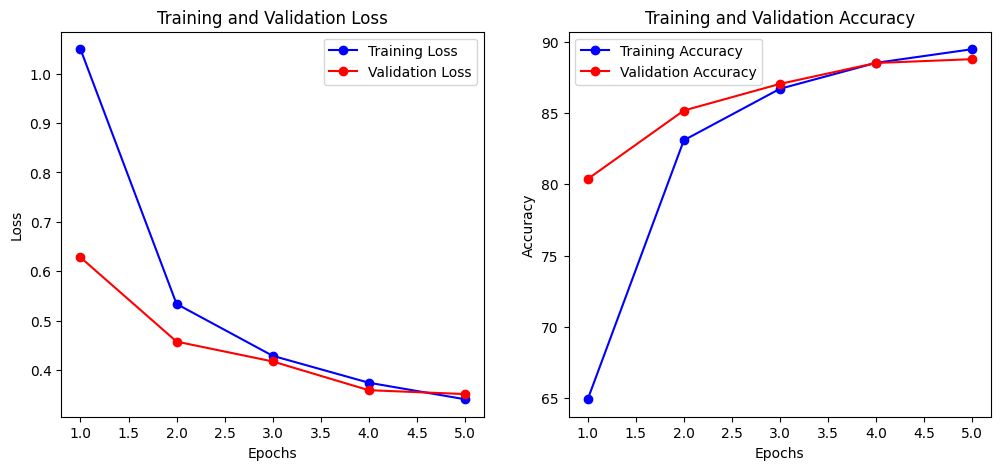

In [35]:
# Assuming train_losses, train_accuracies, val_losses, val_accuracies are available
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


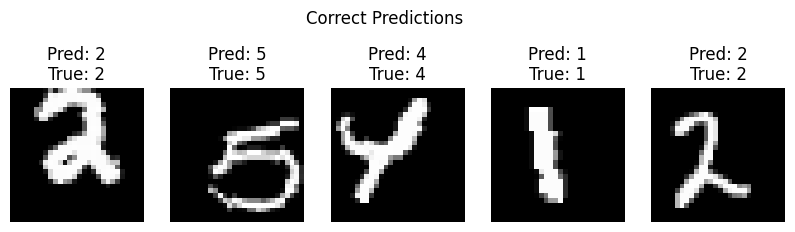

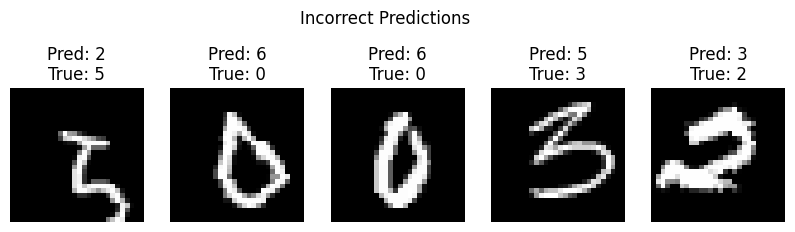

In [38]:
def plot_samples(samples, title):
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i, (img, pred, label) in enumerate(samples):
        axes[i].imshow(img.cpu().squeeze(), cmap='gray')
        axes[i].set_title(f'Pred: {pred}\nTrue: {label}')
        axes[i].axis('off')
    plt.suptitle(title)

# Assume correct_samples and incorrect_samples are collected from the validate_model function
plot_samples(correct_samples, 'Correct Predictions')
plot_samples(incorrect_samples, 'Incorrect Predictions')
plt.show()